## Загрузка датасета

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd ./drive/MyDrive/OS-Action-Prediction/src/model/dataset

/content/drive/MyDrive/OS-Action-Prediction/src/model/dataset


In [3]:
!unzip ./syscalls_dataset.zip

Archive:  ./syscalls_dataset.zip
  inflating: syscalls_dataset.csv    


In [4]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd


In [5]:
dataset = pd.read_csv("syscalls_dataset.csv")

In [6]:
dataset

,last syscalls,syscall
0,"kwin_x11syscallreadsyscall(5, ""\1\0\0\0\0\0\0\...","kwin_x11syscallwritevsyscall(3, [{iov_base=""\2..."
1,_opt_google_chrome_chromesyscallepoll_waitsysc...,_opt_google_chrome_chromesyscallsendtosyscall(...
2,"_usr_lib_xorg_Xorgsyscallwritevsyscall(103, [{...","_usr_lib_xorg_Xorgsyscallwritevsyscall(103, [{..."
3,"_usr_lib_xorg_Xorgsyscallioctlsyscall(18, DRM_...","_usr_lib_xorg_Xorgsyscallreadsyscall(18, ""\2\0..."
4,_opt_google_chrome_chromesyscallepoll_waitsysc...,_opt_google_chrome_chromesyscallepoll_waitsysc...
...,...,...
366027,"chromesyscallepoll_waitsyscall(29, [{events=EP...","chromesyscallsendtosyscall(106, ""\10\0\0\0h\0\..."
366028,"at-spi2-registrsyscallrecvmsgsyscall(5, {msg_n...","at-spi2-registrsyscallrecvmsgsyscall(5, {msg_n..."
366029,"Xorgsyscallrecvmsgsyscall(53, {msg_name=NULL, ...","Xorgsyscallioctlsyscall(20, DRM_IOCTL_I915_GEM..."
366030,"Xorgsyscallrecvmsgsyscall(86, {msg_namelen=0},...","Xorgsyscallwritevsyscall(86, [{iov_base=""\1\0v..."


In [7]:
from sklearn.utils import shuffle

dataset = shuffle(dataset)

In [8]:
dataset

,last syscalls,syscall
97437,_opt_google_chrome_chromesyscallsendtosyscall(...,_opt_google_chrome_chromesyscallfutexsyscall(0...
27028,"kwin_x11syscallfutexsyscall(0x7ffd6c8c0548, FU...","kwin_x11syscallwritesyscall(5, ""\1\0\0\0\0\0\0..."
99482,"Xorgsyscallsetitimersyscall(ITIMER_REAL, {it_i...","Xorgsyscallwritevsyscall(71, [{iov_base=""#\203..."
208831,"baloorunnersyscallwritesyscall(5, ""\1\0\0\0\0\...","baloorunnersyscallrecvmsgsyscall(3, {msg_name=..."
83487,"_usr_sbin_NetworkManagersyscallwritesyscall(7,...","_usr_sbin_NetworkManagersyscallwritesyscall(7,..."
...,...,...
316925,_opt_google_chrome_chromesyscallpollsyscall([{...,_opt_google_chrome_chromesyscallpollsyscall([{...
127106,_usr_bin_kwin_x11syscallfutexsyscall(0x7ffdbd7...,"_usr_bin_kwin_x11syscallrecvmsgsyscall(3, {msg..."
195963,"plasmashellsyscallrecvmsgsyscall(6, {msg_name=...","plasmashellsyscallpollsyscall([{fd=6, events=P..."
145260,"_usr_bin_plasmashellsyscallpollsyscall([{fd=6,...","_usr_bin_plasmashellsyscallreadsyscall(29, ""\3..."


## Выбор девайса

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [ ]:
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import torch
from torch.nn import Embedding, Linear, LSTM, Module, Sigmoid, Tanh
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm import tqdm
import re
import time

## Разбиение данных на токены

In [ ]:
import re

def tokenizer(syscalls):
    syscalls = syscalls.split(sep='last_n_syscalls')
    tokens = []

    for syscall in syscalls:
        str = syscall.split(sep='syscall')
        str = [s if len(s) > 0 else '<pad>' for s in str]
        tokens.extend([str[0], str[1], str[2], str[3]])

    return tokens

## Преобразование токены в коды

In [ ]:
from collections import Counter

In [ ]:
def token_to_sequence(tokens, token2index):
    seq = []
    for token in tokens:
        index = token2index.get(token, len(token2index) - 1) # len(token2index) - 1 означает неизвестное слово
        seq.append(index)

    return seq

## Класс данных системных вызовов для обучения

In [ ]:
tokenizer(dataset.iloc[3]['last syscalls'])

['kwin_x11',
 'futex',
 '(0x7ffd6c8c05c8, FUTEX_WAKE_PRIVATE, 1)',
 '1',
 'kwin_x11',
 'poll',
 '([{fd=3, events=POLLIN}], 1, -1)',
 '1',
 'kwin_x11',
 'recvmsg',
 '(3, {msg_name=NULL, msg_namelen=0, msg_iov=[{iov_base="\\1\\1\\264}\\0\\0\\0\\0m\\7\\0\\0\\314\\343\\241\\1\\200\\0w\\0\\200\\0w\\0\\0\\0\\0\\0\\0\\0\\0\\0", iov_len=4096}], msg_iovlen=1, msg_controllen=0, msg_flags=0}, 0)',
 '32',
 'kwin_x11',
 'futex',
 '(0x7ffd6c8c14a8, FUTEX_WAKE_PRIVATE, 1)',
 '1',
 'kwin_x11',
 'futex',
 '(0x5608242cc868, FUTEX_WAKE_PRIVATE, 1)',
 '0']

In [ ]:
def add_tokens_to_index(index, tokens_counter):
    for token in tokens_counter.most_common():
        if token[0] not in index:
          index[token[0]] = len(index)
    return index

class SyscallDataset(Dataset):
    def __init__(self, dataset, token_size):
        self.dataset = dataset

        # Разбиваем системные вызовы на токены
        self.last_syscalls_tokens = [tokenizer(self.dataset.iloc[i]['last syscalls']) for i in range(len(self.dataset))]
        self.syscall_tokens = [tokenizer(self.dataset.iloc[i]['syscall']) for i in range(len(self.dataset))]

        # Все токены встретившихся системных вызовов
        syscalls_names = [last_syscall[j+1] for last_syscall in self.last_syscalls_tokens
                              for j in [*range(len(last_syscall))][::len(self.syscall_tokens[0])]]

        syscalls_names.extend([syscall[1] for syscall in self.syscall_tokens])

        # Все токены встретившихся команд
        command_names = [last_syscall[j] for last_syscall in self.last_syscalls_tokens
                              for j in [*range(len(last_syscall))][::len(self.syscall_tokens[0])]]

        command_names.extend([syscall[0] for syscall in self.syscall_tokens])

        # Индексируем встречающиеся названия системных вызовов по их встречаемости
        syscall_names_tokens_counter = Counter(syscalls_names)

        most_common_token2index = {'<pad>': 0}
        most_common_token2index = add_tokens_to_index(most_common_token2index, syscall_names_tokens_counter)

        # Все названия встретившихся системных вызовов
        self.syscalls_name = syscall_names_tokens_counter.keys()

        # Добавление токенов названий команд для индексации
        command_names_tokens_counter = Counter(command_names)
        most_common_token2index = add_tokens_to_index(most_common_token2index, command_names_tokens_counter)


        # Все названия встретившихся команд
        self.сommands_name = list(command_names_tokens_counter.keys())

        # Добавление оставшихся токенов для индексации
        left_tokens_counter = Counter()

        for syscalls_token in self.last_syscalls_tokens:
            for token in syscalls_token:
                if token not in self.syscalls_name and token not in self.сommands_name:
                    left_tokens_counter.update({token: 1})

        most_common_token2index = add_tokens_to_index(most_common_token2index, left_tokens_counter)

        # Оставляем только token_size - 1 самых популярных токенов
        filtered_most_common_token2index = {k: v for k, v in most_common_token2index.items() if v < token_size - 1}

        # Словарь, отображающий токены в коды
        self.token2index = dict()

        # Словарь, отображающий коды в токены
        self.index2token = dict()

        print(len(filtered_most_common_token2index))
        self.token2index.update(filtered_most_common_token2index)
        self.token2index["<unk>"] = len(self.token2index)
        print(len(self.token2index))
        self.index2token = {v: k for k, v in self.token2index.items()}
        self.token_size = min(len(self.index2token), token_size)
        self.vocabulary = [self.index2token[i] for i in range(len(self.syscalls_name))]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, ix):
        X = torch.LongTensor(
            token_to_sequence(self.last_syscalls_tokens[ix], self.token2index)
        )

        y = token_to_sequence(self.syscall_tokens[ix], self.token2index)[1] - 1 # -1 потому что padding 0

        return X, y


## Класс Bidirectional LSTM нейронной сети системных вызовов

In [ ]:
class SyscallBiLSTMNetwork(Module):
    def __init__(
        self,
        token_size,
        syscalls_name_len,
        embedding_dim=4,
        rnn_num_layers=1,
        rnn_dropout_prob=0.0,
        hidden_size=16,
        max_norm=2,
    ):
        super().__init__()

        self.embedding = Embedding(
            token_size,
            embedding_dim,
            padding_idx=0,
            norm_type=2,
            max_norm=max_norm
        )

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_size,
            num_layers=rnn_num_layers,
            bidirectional = True,
            dropout=rnn_dropout_prob,
            batch_first=True,
        )

        self.linear = nn.Linear(
            2 * hidden_size,
            syscalls_name_len
          )

    def forward(self, x):
        embs = self.embedding(x)  # (n_samples, 45, embedding_dim)
        out, (hidden_state,cell_state) = self.lstm(embs)
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        logits = self.linear(hidden)
        return logits

def compute_loss_accuracy_perfomance(loss_f, net, dataloader):
    net.eval()
    all_losses = []
    all_accuracy = []
    all_perfomance = 0

    for X_batch, y_batch in dataloader:
        time_start = time.time_ns()
        pred = net(X_batch)
        time_end = time.time_ns()
        all_perfomance += (time_end - time_start)

        all_losses.append(loss_f(pred, y_batch).item())

        pred = pred.argmax(dim=1)
        all_accuracy.append((pred == y_batch).float().mean())

    return np.mean(all_losses), np.mean(all_accuracy), (all_perfomance // len(dataloader.sampler.indices))


## Класс нейронной сети системных вызовов

In [ ]:
class SyscallNetwork(Module):
    def __init__(
        self,
        token_size,
        syscalls_name_len,
        embedding_dim=4,
        max_norm=2,
    ):
        super().__init__()

        self.embedding = Embedding(
            token_size,
            embedding_dim,
            padding_idx=0,
            norm_type=2,
            max_norm=max_norm
        )

        self.linear = Linear(4 * 5 * embedding_dim, syscalls_name_len)

    def forward(self, x):
        emb = self.embedding(x)  # (n_samples, 45, 2)
        emb = emb.reshape(x.shape[0], -1)
        x = self.linear(emb)

        return x

def compute_loss_accuracy_perfomance(loss, net, dataloader):
    net.eval()
    all_losses = []
    all_accuracy = []
    all_perfomance = 0

    for X_batch, y_batch in dataloader:
        time_start = time.time_ns()
        pred = net(X_batch)
        time_end = time.time_ns()
        all_perfomance += (time_end - time_start)

        all_losses.append(loss(pred, y_batch).item())

        pred = pred.argmax(dim=1)
        all_accuracy.append((pred == y_batch).float().mean())

    return np.mean(all_losses), np.mean(all_accuracy), (all_perfomance // len(dataloader.sampler.indices))


#### Задание гиперпараметров

In [ ]:
n_epochs = 50
train_split = 0.7
val_split = 0.1
batch_size = 1024

#### Функция потерь

In [ ]:
loss_f = torch.nn.CrossEntropyLoss()

## Создание тренировочного и валидационного датасета

In [ ]:
token_size = 500 # максимальное количество токенов

syscalldataset = SyscallDataset(dataset, token_size)


n_samples = len(dataset)
train_ix = int(n_samples * train_split)
val_ix = int(n_samples * val_split) + train_ix

train_indices, val_indices, test_indices = np.arange(train_ix), np.arange(train_ix, val_ix), np.arange(val_ix, n_samples)

train_dataloader = DataLoader(
        syscalldataset, sampler=SubsetRandomSampler(train_indices),
        batch_size=batch_size
)
val_dataloader = DataLoader(
        syscalldataset, sampler=SubsetRandomSampler(val_indices),
        batch_size=batch_size
)
test_dataloader = DataLoader(
        syscalldataset, sampler=SubsetRandomSampler(test_indices),
        batch_size=batch_size
)

499
500


## Создание Bidirectional LSTM нейронной сети и оптимайзера


In [ ]:
token_size = 500 # максимальное количество токенов
embedding_dim = 4
hidden_size = 16
max_norm = 2
rnn_num_layers=1
lr = 3e-3

lstm_net = SyscallBiLSTMNetwork(
        token_size=token_size,
        syscalls_name_len=len(syscalldataset.syscalls_name),
        embedding_dim=embedding_dim,
        rnn_num_layers=rnn_num_layers,
        hidden_size=hidden_size,
        max_norm=max_norm,
)

lstm_optimizer = torch.optim.Adam(
        lstm_net.parameters(),
        lr=lr,
)

## Обучение BiLSTM нейронной сети и сохранение лучшей модели

In [ ]:
emb_history = []
lstm_val_accuracy_history = []
lstm_val_loss_history = []
lstm_val_perfomance_history = []
lstm_train_loss_history = []
lstm_train_accuracy_history = []
best_val_acc = 0.0

for epoch in range(n_epochs):
    lstm_net.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        lstm_optimizer.zero_grad()
        pred = lstm_net(X_batch)
        loss = loss_f(pred, y_batch)
        loss.backward()
        lstm_optimizer.step()


    if epoch % 1 == 0 or epoch == n_epochs:
        train_loss, train_acc, _ = compute_loss_accuracy_perfomance(loss_f, lstm_net, train_dataloader)
        val_loss, val_acc, val_perf = compute_loss_accuracy_perfomance(loss_f, lstm_net, val_dataloader)
        print(f"Epoch: {epoch}, train loss: {train_loss=:.3f}, validation loss {val_loss=:.3f}")
        print(f'Perfomance {val_perf}')
        print(f'Accuracy: {val_acc}')
        lstm_train_loss_history.append(train_loss)
        lstm_train_accuracy_history.append(train_acc)
        lstm_val_loss_history.append(val_loss)
        lstm_val_accuracy_history.append(val_acc)
        lstm_val_perfomance_history.append(val_perf)

        if (val_acc > best_val_acc):
            best_val_acc = val_acc
            torch.save(lstm_net.state_dict(), 'best-model-syscall-prediction-lstm.pt')


    # # Prepare DataFrame

    # weights = lstm_net.embedding.weight.detach().clone().numpy()[:len(syscalldataset.vocabulary)]

    # df = pd.DataFrame(weights, columns=[f"dim_{i}" for i in range(embedding_dim)])
    # df["epoch"] = epoch
    # df["token"] = syscalldataset.vocabulary

    # emb_history.append(df)

100%|██████████| 251/251 [00:26<00:00,  9.45it/s]


Epoch: 0, train loss: train_loss=1.876, validation loss val_loss=1.884
Perfomance 27733
Accuracy: 0.3856305480003357


100%|██████████| 251/251 [00:23<00:00, 10.90it/s]


Epoch: 1, train loss: train_loss=1.200, validation loss val_loss=1.206
Perfomance 32820
Accuracy: 0.6604149341583252


100%|██████████| 251/251 [00:22<00:00, 10.97it/s]


Epoch: 2, train loss: train_loss=0.967, validation loss val_loss=0.976
Perfomance 29862
Accuracy: 0.7227407097816467


100%|██████████| 251/251 [00:24<00:00, 10.41it/s]


Epoch: 3, train loss: train_loss=0.843, validation loss val_loss=0.855
Perfomance 27488
Accuracy: 0.7531425952911377


100%|██████████| 251/251 [00:24<00:00, 10.07it/s]


Epoch: 4, train loss: train_loss=0.767, validation loss val_loss=0.783
Perfomance 28283
Accuracy: 0.7687897086143494


100%|██████████| 251/251 [00:25<00:00,  9.95it/s]


Epoch: 5, train loss: train_loss=0.720, validation loss val_loss=0.736
Perfomance 28019
Accuracy: 0.7845317721366882


100%|██████████| 251/251 [00:26<00:00,  9.63it/s]


Epoch: 6, train loss: train_loss=0.679, validation loss val_loss=0.697
Perfomance 29790
Accuracy: 0.7987590432167053


100%|██████████| 251/251 [00:23<00:00, 10.60it/s]


Epoch: 7, train loss: train_loss=0.655, validation loss val_loss=0.672
Perfomance 36961
Accuracy: 0.804511308670044


100%|██████████| 251/251 [00:25<00:00,  9.87it/s]


Epoch: 8, train loss: train_loss=0.639, validation loss val_loss=0.658
Perfomance 32221
Accuracy: 0.807187557220459


100%|██████████| 251/251 [00:24<00:00, 10.30it/s]


Epoch: 9, train loss: train_loss=0.620, validation loss val_loss=0.639
Perfomance 29101
Accuracy: 0.8142669200897217


100%|██████████| 251/251 [00:24<00:00, 10.12it/s]


Epoch: 10, train loss: train_loss=0.603, validation loss val_loss=0.622
Perfomance 28417
Accuracy: 0.8189399242401123


100%|██████████| 251/251 [00:24<00:00, 10.32it/s]


Epoch: 11, train loss: train_loss=0.587, validation loss val_loss=0.609
Perfomance 28036
Accuracy: 0.8195345401763916


100%|██████████| 251/251 [00:24<00:00, 10.08it/s]


Epoch: 12, train loss: train_loss=0.580, validation loss val_loss=0.599
Perfomance 27880
Accuracy: 0.8239961862564087


100%|██████████| 251/251 [00:23<00:00, 10.67it/s]


Epoch: 13, train loss: train_loss=0.579, validation loss val_loss=0.600
Perfomance 32712
Accuracy: 0.8231666088104248


100%|██████████| 251/251 [00:23<00:00, 10.73it/s]


Epoch: 14, train loss: train_loss=0.564, validation loss val_loss=0.585
Perfomance 35380
Accuracy: 0.8269136548042297


100%|██████████| 251/251 [00:23<00:00, 10.48it/s]


Epoch: 15, train loss: train_loss=0.557, validation loss val_loss=0.578
Perfomance 27815
Accuracy: 0.8280823230743408


100%|██████████| 251/251 [00:23<00:00, 10.62it/s]


Epoch: 16, train loss: train_loss=0.548, validation loss val_loss=0.567
Perfomance 27572
Accuracy: 0.8300760984420776


100%|██████████| 251/251 [00:26<00:00,  9.44it/s]


Epoch: 17, train loss: train_loss=0.543, validation loss val_loss=0.565
Perfomance 27376
Accuracy: 0.8312218189239502


100%|██████████| 251/251 [00:23<00:00, 10.60it/s]


Epoch: 18, train loss: train_loss=0.536, validation loss val_loss=0.558
Perfomance 27843
Accuracy: 0.8331878185272217


100%|██████████| 251/251 [00:24<00:00, 10.20it/s]


Epoch: 19, train loss: train_loss=0.527, validation loss val_loss=0.550
Perfomance 30824
Accuracy: 0.8350003361701965


100%|██████████| 251/251 [00:23<00:00, 10.67it/s]


Epoch: 20, train loss: train_loss=0.531, validation loss val_loss=0.553
Perfomance 42050
Accuracy: 0.8350317478179932


100%|██████████| 251/251 [00:23<00:00, 10.55it/s]


Epoch: 21, train loss: train_loss=0.520, validation loss val_loss=0.545
Perfomance 27489
Accuracy: 0.8354443311691284


100%|██████████| 251/251 [00:24<00:00, 10.32it/s]


Epoch: 22, train loss: train_loss=0.522, validation loss val_loss=0.547
Perfomance 27681
Accuracy: 0.836622953414917


100%|██████████| 251/251 [00:23<00:00, 10.62it/s]


Epoch: 23, train loss: train_loss=0.523, validation loss val_loss=0.548
Perfomance 27833
Accuracy: 0.8371290564537048


100%|██████████| 251/251 [00:26<00:00,  9.65it/s]


Epoch: 24, train loss: train_loss=0.512, validation loss val_loss=0.538
Perfomance 28074
Accuracy: 0.8373546004295349


100%|██████████| 251/251 [00:22<00:00, 10.93it/s]


Epoch: 25, train loss: train_loss=0.519, validation loss val_loss=0.544
Perfomance 36739
Accuracy: 0.8351687788963318


100%|██████████| 251/251 [00:24<00:00, 10.44it/s]


Epoch: 26, train loss: train_loss=0.511, validation loss val_loss=0.538
Perfomance 34282
Accuracy: 0.8376437425613403


100%|██████████| 251/251 [00:24<00:00, 10.33it/s]


Epoch: 27, train loss: train_loss=0.506, validation loss val_loss=0.534
Perfomance 39344
Accuracy: 0.8401679396629333


100%|██████████| 251/251 [00:25<00:00,  9.87it/s]


Epoch: 28, train loss: train_loss=0.500, validation loss val_loss=0.527
Perfomance 27989
Accuracy: 0.8414642810821533


100%|██████████| 251/251 [00:25<00:00, 10.01it/s]


Epoch: 29, train loss: train_loss=0.500, validation loss val_loss=0.528
Perfomance 27730
Accuracy: 0.8407633304595947


100%|██████████| 251/251 [00:24<00:00, 10.13it/s]


Epoch: 30, train loss: train_loss=0.509, validation loss val_loss=0.538
Perfomance 27821
Accuracy: 0.8389922380447388


100%|██████████| 251/251 [00:26<00:00,  9.63it/s]


Epoch: 31, train loss: train_loss=0.500, validation loss val_loss=0.530
Perfomance 28145
Accuracy: 0.8395975828170776


100%|██████████| 251/251 [00:23<00:00, 10.55it/s]


Epoch: 32, train loss: train_loss=0.493, validation loss val_loss=0.523
Perfomance 30057
Accuracy: 0.8409474492073059


100%|██████████| 251/251 [00:24<00:00, 10.29it/s]


Epoch: 33, train loss: train_loss=0.488, validation loss val_loss=0.520
Perfomance 36958
Accuracy: 0.8442897796630859


100%|██████████| 251/251 [00:23<00:00, 10.64it/s]


Epoch: 34, train loss: train_loss=0.494, validation loss val_loss=0.524
Perfomance 37463
Accuracy: 0.8438493609428406


100%|██████████| 251/251 [00:23<00:00, 10.90it/s]


Epoch: 35, train loss: train_loss=0.489, validation loss val_loss=0.520
Perfomance 32362
Accuracy: 0.8421853184700012


100%|██████████| 251/251 [00:24<00:00, 10.17it/s]


Epoch: 36, train loss: train_loss=0.490, validation loss val_loss=0.520
Perfomance 28093
Accuracy: 0.8435474038124084


100%|██████████| 251/251 [00:24<00:00, 10.36it/s]


Epoch: 37, train loss: train_loss=0.485, validation loss val_loss=0.516
Perfomance 28440
Accuracy: 0.8450164794921875


100%|██████████| 251/251 [00:26<00:00,  9.49it/s]


Epoch: 38, train loss: train_loss=0.488, validation loss val_loss=0.521
Perfomance 27967
Accuracy: 0.8417206406593323


100%|██████████| 251/251 [00:24<00:00, 10.40it/s]


Epoch: 39, train loss: train_loss=0.483, validation loss val_loss=0.515
Perfomance 27882
Accuracy: 0.8444211483001709


100%|██████████| 251/251 [00:24<00:00, 10.14it/s]


Epoch: 40, train loss: train_loss=0.482, validation loss val_loss=0.514
Perfomance 28095
Accuracy: 0.844653844833374


100%|██████████| 251/251 [00:23<00:00, 10.54it/s]


Epoch: 41, train loss: train_loss=0.480, validation loss val_loss=0.515
Perfomance 28056
Accuracy: 0.8458852767944336


100%|██████████| 251/251 [00:23<00:00, 10.69it/s]


Epoch: 42, train loss: train_loss=0.487, validation loss val_loss=0.523
Perfomance 36487
Accuracy: 0.8451935648918152


100%|██████████| 251/251 [00:24<00:00, 10.36it/s]


Epoch: 43, train loss: train_loss=0.477, validation loss val_loss=0.511
Perfomance 36982
Accuracy: 0.8448337316513062


100%|██████████| 251/251 [00:23<00:00, 10.58it/s]


Epoch: 44, train loss: train_loss=0.478, validation loss val_loss=0.511
Perfomance 31795
Accuracy: 0.8473415374755859


100%|██████████| 251/251 [00:25<00:00,  9.67it/s]


Epoch: 45, train loss: train_loss=0.484, validation loss val_loss=0.517
Perfomance 27651
Accuracy: 0.8460637331008911


100%|██████████| 251/251 [00:25<00:00,  9.98it/s]


Epoch: 46, train loss: train_loss=0.473, validation loss val_loss=0.509
Perfomance 27780
Accuracy: 0.8480325937271118


100%|██████████| 251/251 [00:25<00:00,  9.90it/s]


Epoch: 47, train loss: train_loss=0.469, validation loss val_loss=0.505
Perfomance 27931
Accuracy: 0.8486692905426025


100%|██████████| 251/251 [00:24<00:00, 10.05it/s]


Epoch: 48, train loss: train_loss=0.466, validation loss val_loss=0.502
Perfomance 28640
Accuracy: 0.8496937155723572


100%|██████████| 251/251 [00:24<00:00, 10.34it/s]


Epoch: 49, train loss: train_loss=0.467, validation loss val_loss=0.502
Perfomance 27891
Accuracy: 0.8495302200317383


In [ ]:
# final_df = pd.concat(emb_history)
# final_df.to_csv("emb.csv", index=False)

## Создание нейронной сети и оптимайзера


In [ ]:
token_size = 500 # максимальное количество токенов
embedding_dim = 4
hidden_size = 16
max_norm = 2
rnn_num_layers=1
lr = 3e-3

net = SyscallNetwork(
        syscalldataset.token_size,
        len(syscalldataset.syscalls_name),
        embedding_dim=embedding_dim,
        max_norm=max_norm,
)

optimizer = torch.optim.Adam(
        net.parameters(),
        lr=lr,
)

## Обучение нейронной сети и сохранение лучшей модели

In [ ]:
emb_history = []
val_accuracy_history = []
val_loss_history = []
val_perfomance_history = []
train_loss_history = []
train_accuracy_history = []
best_val_acc = 0.0

for epoch in range(n_epochs):
    net.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        pred = net(X_batch)
        loss = loss_f(pred, y_batch)
        loss.backward()
        optimizer.step()


    if epoch % 1 == 0 or epoch == n_epochs:
        train_loss, train_acc, _ = compute_loss_accuracy_perfomance(loss_f, net, train_dataloader)
        val_loss, val_acc, val_perf = compute_loss_accuracy_perfomance(loss_f, net, val_dataloader)
        print(f"Epoch: {epoch}, train loss: {train_loss=:.3f}, validation loss {val_loss=:.3f}")
        print(f'Perfomance {val_perf}')
        print(f'Accuracy: {val_acc}')
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_acc)
        val_perfomance_history.append(val_perf)

        if (val_acc > best_val_acc):
            best_val_acc = val_acc
            torch.save(net.state_dict(), 'best-model-syscall-prediction.pt')


#     # Prepare DataFrame

#     weights = net.embedding.weight.detach().clone().numpy()[:len(syscalldataset.vocabulary)]

#     df = pd.DataFrame(weights, columns=[f"dim_{i}" for i in range(embedding_dim)])
#     df["epoch"] = epoch
#     df["token"] = syscalldataset.vocabulary

#     emb_history.append(df)

# final_df = pd.concat(emb_history)
# final_df.to_csv("emb.csv", index=False)

100%|██████████| 251/251 [00:10<00:00, 23.87it/s]


Epoch: 0, train loss: train_loss=1.017, validation loss val_loss=1.023
Perfomance 2948
Accuracy: 0.7084163427352905


100%|██████████| 251/251 [00:10<00:00, 23.47it/s]


Epoch: 1, train loss: train_loss=0.794, validation loss val_loss=0.806
Perfomance 4920
Accuracy: 0.7682992815971375


100%|██████████| 251/251 [00:08<00:00, 30.22it/s]


Epoch: 2, train loss: train_loss=0.718, validation loss val_loss=0.734
Perfomance 3018
Accuracy: 0.7869167923927307


100%|██████████| 251/251 [00:10<00:00, 23.35it/s]


Epoch: 3, train loss: train_loss=0.677, validation loss val_loss=0.693
Perfomance 2983
Accuracy: 0.7970829010009766


100%|██████████| 251/251 [00:10<00:00, 24.81it/s]


Epoch: 4, train loss: train_loss=0.650, validation loss val_loss=0.669
Perfomance 2901
Accuracy: 0.8037917613983154


100%|██████████| 251/251 [00:09<00:00, 25.83it/s]


Epoch: 5, train loss: train_loss=0.633, validation loss val_loss=0.652
Perfomance 2896
Accuracy: 0.8076487183570862


100%|██████████| 251/251 [00:10<00:00, 24.90it/s]


Epoch: 6, train loss: train_loss=0.618, validation loss val_loss=0.638
Perfomance 3487
Accuracy: 0.8136765956878662


100%|██████████| 251/251 [00:10<00:00, 24.25it/s]


Epoch: 7, train loss: train_loss=0.608, validation loss val_loss=0.631
Perfomance 3013
Accuracy: 0.8150971531867981


100%|██████████| 251/251 [00:08<00:00, 28.17it/s]


Epoch: 8, train loss: train_loss=0.601, validation loss val_loss=0.624
Perfomance 3084
Accuracy: 0.8167526125907898


100%|██████████| 251/251 [00:10<00:00, 23.24it/s]


Epoch: 9, train loss: train_loss=0.594, validation loss val_loss=0.618
Perfomance 4667
Accuracy: 0.8166255354881287


100%|██████████| 251/251 [00:09<00:00, 26.12it/s]


Epoch: 10, train loss: train_loss=0.589, validation loss val_loss=0.615
Perfomance 3189
Accuracy: 0.8198571801185608


100%|██████████| 251/251 [00:10<00:00, 24.48it/s]


Epoch: 11, train loss: train_loss=0.584, validation loss val_loss=0.610
Perfomance 4832
Accuracy: 0.8213962316513062


100%|██████████| 251/251 [00:10<00:00, 24.09it/s]


Epoch: 12, train loss: train_loss=0.581, validation loss val_loss=0.605
Perfomance 4864
Accuracy: 0.8197400569915771


100%|██████████| 251/251 [00:09<00:00, 27.34it/s]


Epoch: 13, train loss: train_loss=0.576, validation loss val_loss=0.602
Perfomance 2977
Accuracy: 0.823040246963501


100%|██████████| 251/251 [00:10<00:00, 23.24it/s]


Epoch: 14, train loss: train_loss=0.573, validation loss val_loss=0.599
Perfomance 3116
Accuracy: 0.8213648796081543


100%|██████████| 251/251 [00:09<00:00, 25.58it/s]


Epoch: 15, train loss: train_loss=0.570, validation loss val_loss=0.597
Perfomance 4137
Accuracy: 0.822324275970459


100%|██████████| 251/251 [00:09<00:00, 27.04it/s]


Epoch: 16, train loss: train_loss=0.567, validation loss val_loss=0.594
Perfomance 2981
Accuracy: 0.8225576877593994


100%|██████████| 251/251 [00:10<00:00, 25.08it/s]


Epoch: 17, train loss: train_loss=0.564, validation loss val_loss=0.591
Perfomance 2874
Accuracy: 0.82567298412323


100%|██████████| 251/251 [00:10<00:00, 24.08it/s]


Epoch: 18, train loss: train_loss=0.562, validation loss val_loss=0.591
Perfomance 3172
Accuracy: 0.8235735297203064


100%|██████████| 251/251 [00:10<00:00, 23.16it/s]


Epoch: 19, train loss: train_loss=0.561, validation loss val_loss=0.589
Perfomance 2951
Accuracy: 0.8230903148651123


100%|██████████| 251/251 [00:10<00:00, 23.83it/s]


Epoch: 20, train loss: train_loss=0.559, validation loss val_loss=0.588
Perfomance 4023
Accuracy: 0.8254953026771545


100%|██████████| 251/251 [00:09<00:00, 25.16it/s]


Epoch: 21, train loss: train_loss=0.556, validation loss val_loss=0.585
Perfomance 2878
Accuracy: 0.8254895806312561


100%|██████████| 251/251 [00:08<00:00, 28.21it/s]


Epoch: 22, train loss: train_loss=0.557, validation loss val_loss=0.586
Perfomance 2896
Accuracy: 0.8255559206008911


100%|██████████| 251/251 [00:10<00:00, 23.97it/s]


Epoch: 23, train loss: train_loss=0.554, validation loss val_loss=0.584
Perfomance 4252
Accuracy: 0.8266217708587646


100%|██████████| 251/251 [00:09<00:00, 26.63it/s]


Epoch: 24, train loss: train_loss=0.552, validation loss val_loss=0.582
Perfomance 2905
Accuracy: 0.8268537521362305


100%|██████████| 251/251 [00:09<00:00, 25.32it/s]


Epoch: 25, train loss: train_loss=0.551, validation loss val_loss=0.581
Perfomance 2943
Accuracy: 0.8276810646057129


100%|██████████| 251/251 [00:09<00:00, 25.45it/s]


Epoch: 26, train loss: train_loss=0.548, validation loss val_loss=0.579
Perfomance 4267
Accuracy: 0.829549252986908


100%|██████████| 251/251 [00:09<00:00, 26.89it/s]


Epoch: 27, train loss: train_loss=0.551, validation loss val_loss=0.581
Perfomance 2901
Accuracy: 0.8253517746925354


100%|██████████| 251/251 [00:10<00:00, 24.01it/s]


Epoch: 28, train loss: train_loss=0.547, validation loss val_loss=0.578
Perfomance 3127
Accuracy: 0.8279630541801453


100%|██████████| 251/251 [00:10<00:00, 23.56it/s]


Epoch: 29, train loss: train_loss=0.545, validation loss val_loss=0.577
Perfomance 4401
Accuracy: 0.8261834383010864


100%|██████████| 251/251 [00:09<00:00, 26.64it/s]


Epoch: 30, train loss: train_loss=0.546, validation loss val_loss=0.578
Perfomance 2931
Accuracy: 0.8285084962844849


100%|██████████| 251/251 [00:09<00:00, 26.40it/s]


Epoch: 31, train loss: train_loss=0.547, validation loss val_loss=0.578
Perfomance 2983
Accuracy: 0.8262562155723572


100%|██████████| 251/251 [00:10<00:00, 23.63it/s]


Epoch: 32, train loss: train_loss=0.544, validation loss val_loss=0.575
Perfomance 4461
Accuracy: 0.8293079733848572


100%|██████████| 251/251 [00:08<00:00, 29.63it/s]


Epoch: 33, train loss: train_loss=0.543, validation loss val_loss=0.575
Perfomance 3053
Accuracy: 0.8299054503440857


100%|██████████| 251/251 [00:12<00:00, 20.58it/s]


Epoch: 34, train loss: train_loss=0.542, validation loss val_loss=0.573
Perfomance 3261
Accuracy: 0.8287726044654846


100%|██████████| 251/251 [00:10<00:00, 23.47it/s]


Epoch: 35, train loss: train_loss=0.541, validation loss val_loss=0.575
Perfomance 3098
Accuracy: 0.8284428119659424


100%|██████████| 251/251 [00:08<00:00, 29.93it/s]


Epoch: 36, train loss: train_loss=0.541, validation loss val_loss=0.572
Perfomance 2963
Accuracy: 0.8273977041244507


100%|██████████| 251/251 [00:10<00:00, 23.57it/s]


Epoch: 37, train loss: train_loss=0.539, validation loss val_loss=0.572
Perfomance 2949
Accuracy: 0.8300532698631287


100%|██████████| 251/251 [00:10<00:00, 23.74it/s]


Epoch: 38, train loss: train_loss=0.541, validation loss val_loss=0.574
Perfomance 2960
Accuracy: 0.8283571004867554


100%|██████████| 251/251 [00:09<00:00, 27.83it/s]


Epoch: 39, train loss: train_loss=0.539, validation loss val_loss=0.572
Perfomance 2918
Accuracy: 0.8300204277038574


100%|██████████| 251/251 [00:10<00:00, 23.63it/s]


Epoch: 40, train loss: train_loss=0.537, validation loss val_loss=0.571
Perfomance 3211
Accuracy: 0.8307356834411621


100%|██████████| 251/251 [00:10<00:00, 24.89it/s]


Epoch: 41, train loss: train_loss=0.537, validation loss val_loss=0.571
Perfomance 4518
Accuracy: 0.8286390900611877


100%|██████████| 251/251 [00:10<00:00, 23.38it/s]


Epoch: 42, train loss: train_loss=0.537, validation loss val_loss=0.569
Perfomance 2825
Accuracy: 0.8294250965118408


100%|██████████| 251/251 [00:09<00:00, 25.41it/s]


Epoch: 43, train loss: train_loss=0.536, validation loss val_loss=0.569
Perfomance 4047
Accuracy: 0.8292858600616455


100%|██████████| 251/251 [00:09<00:00, 25.56it/s]


Epoch: 44, train loss: train_loss=0.535, validation loss val_loss=0.569
Perfomance 2910
Accuracy: 0.8323097825050354


100%|██████████| 251/251 [00:08<00:00, 28.35it/s]


Epoch: 45, train loss: train_loss=0.535, validation loss val_loss=0.569
Perfomance 2934
Accuracy: 0.8315894603729248


100%|██████████| 251/251 [00:10<00:00, 23.79it/s]


Epoch: 46, train loss: train_loss=0.534, validation loss val_loss=0.569
Perfomance 4090
Accuracy: 0.8289260864257812


100%|██████████| 251/251 [00:09<00:00, 26.74it/s]


Epoch: 47, train loss: train_loss=0.533, validation loss val_loss=0.568
Perfomance 2992
Accuracy: 0.8297913074493408


100%|██████████| 251/251 [00:09<00:00, 26.33it/s]


Epoch: 48, train loss: train_loss=0.535, validation loss val_loss=0.569
Perfomance 2939
Accuracy: 0.8303987979888916


100%|██████████| 251/251 [00:11<00:00, 21.29it/s]


Epoch: 49, train loss: train_loss=0.533, validation loss val_loss=0.567
Perfomance 4660
Accuracy: 0.8315680623054504


## Графики loss и accuracy

In [ ]:
import matplotlib.pyplot as plt

### Графики BiLSTM

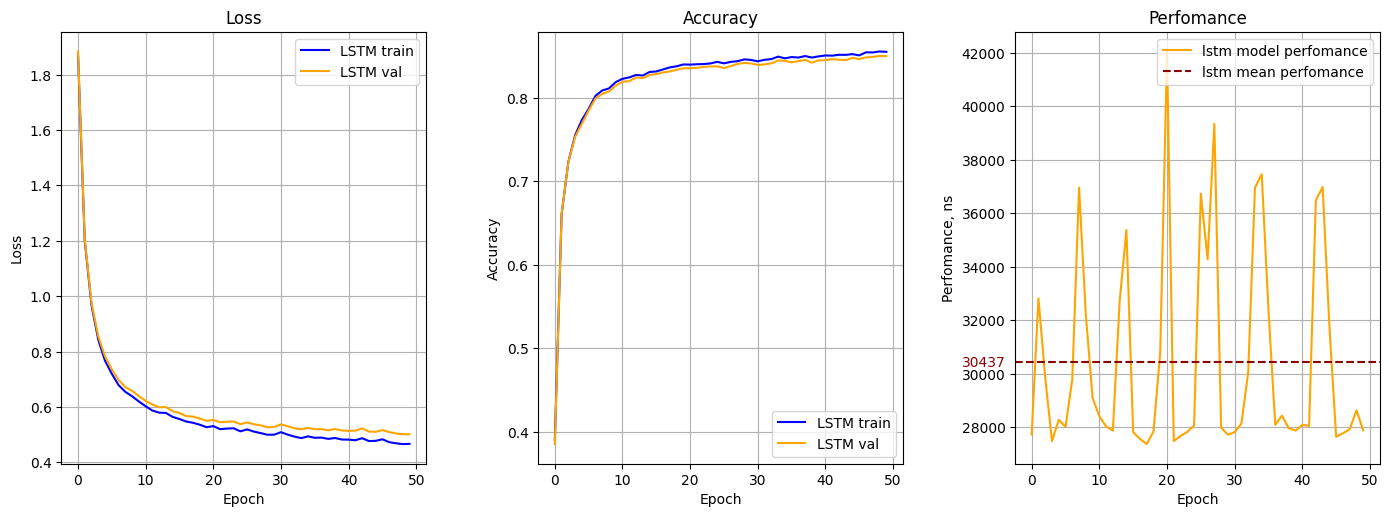

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.tight_layout(pad=5.0)

plt.subplot(1, 3, 1)
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(lstm_train_loss_history, color='blue', label='LSTM train')
plt.plot(lstm_val_loss_history, color='orange', label='LSTM val')
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(lstm_train_accuracy_history, color='blue', label='LSTM train')
plt.plot(lstm_val_accuracy_history, color='orange', label='LSTM val')
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Perfomance")
plt.xlabel('Epoch')
plt.ylabel('Perfomance, ns')
plt.grid(True)
plt.plot(lstm_val_perfomance_history, color='orange', label='lstm model perfomance')
plt.axhline(y=np.nanmean(lstm_val_perfomance_history), color='darkred', linestyle='--', label='lstm mean perfomance')
plt.text(-3.8, np.nanmean(lstm_val_perfomance_history), "{:.0f}".format(np.nanmean(lstm_val_perfomance_history)), color="darkred",
        ha="right", va="center")

plt.legend()

plt.show()

### Сравнение BiLSTM и обычной нейронных сетей

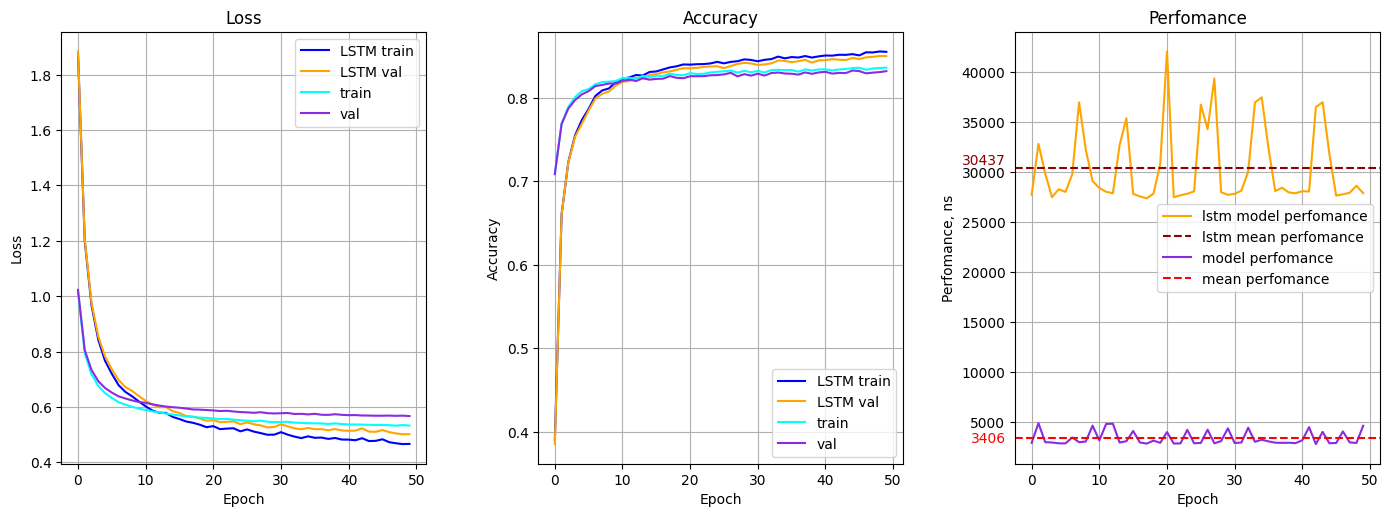

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.tight_layout(pad=5.0)

plt.subplot(1, 3, 1)
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(lstm_train_loss_history, color='blue', label='LSTM train')
plt.plot(lstm_val_loss_history, color='orange', label='LSTM val')
plt.plot(train_loss_history, color='aqua', label='train')
plt.plot(val_loss_history, color='blueviolet', label='val')
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(lstm_train_accuracy_history, color='blue', label='LSTM train')
plt.plot(lstm_val_accuracy_history, color='orange', label='LSTM val')
plt.plot(train_accuracy_history, color='aqua', label='train')
plt.plot(val_accuracy_history, color='blueviolet', label='val')
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Perfomance")
plt.xlabel('Epoch')
plt.ylabel('Perfomance, ns')
plt.grid(True)

plt.plot(lstm_val_perfomance_history, color='orange', label='lstm model perfomance')
plt.axhline(y=np.nanmean(lstm_val_perfomance_history), color='darkred', linestyle='--', label='lstm mean perfomance')
plt.text(-3.8, np.nanmean(lstm_val_perfomance_history) + 700, "{:.0f}".format(np.nanmean(lstm_val_perfomance_history)), color="darkred",
        ha="right", va="center")


plt.plot(val_perfomance_history, color='blueviolet', label='model perfomance')
plt.axhline(y=np.nanmean(val_perfomance_history), color='red', linestyle='--', label='mean perfomance')
plt.text(-3.8, np.nanmean(val_perfomance_history), "{:.0f}".format(np.nanmean(val_perfomance_history)), color="red",
        ha="right", va="center")

plt.legend()
plt.show()

In [ ]:
print('LSTM mean perfomance ', np.nanmean(lstm_val_perfomance_history))
print('Mean perfomance ', np.nanmean(val_perfomance_history))


LSTM mean perfomance  30436.8
Mean perfomance  3406.12


### График embeddings

In [ ]:
import plotly
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
# df = pd.read_csv("emb.csv")

In [ ]:
# px.scatter(
#     df,
#     x='dim_0', y='dim_1',
#     text = 'token',
#     animation_frame='epoch',
#     animation_group='token',
#     # size='pop',
#     # color='continent',
#     hover_name='token'
#     # log_x=True,
#     # size_max=55,
#     # range_x=[100, 100000], range_y=[25, 90]
# )

### Результаты лучшей модели на тестовой выборке

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/Diplom2024/Code/dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Diplom2024/Code/dataset


## Лучшая BiLSTM модель

In [ ]:
import torch

best_lstm_model = SyscallBiLSTMNetwork(
        token_size=token_size,
        syscalls_name_len=len(syscalldataset.syscalls_name),
        embedding_dim=embedding_dim,
        rnn_num_layers=rnn_num_layers,
        hidden_size=hidden_size,
        max_norm=max_norm,
)

best_lstm_model.load_state_dict(torch.load('best-model-syscall-prediction-lstm.pt'))
best_lstm_model.eval()

SyscallBiLSTMNetwork(
  (embedding): Embedding(500, 4, padding_idx=0, max_norm=2)
  (lstm): LSTM(4, 16, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=32, out_features=157, bias=True)
)

In [ ]:
train_loss, train_accuracy, train_perfomance = compute_loss_accuracy_perfomance(loss_f, best_lstm_model, train_dataloader)
val_loss, val_accuracy, val_perfomance = compute_loss_accuracy_perfomance(loss_f, best_lstm_model, val_dataloader)
test_loss, test_accuracy, test_perfomance = compute_loss_accuracy_perfomance(loss_f, best_lstm_model, test_dataloader)

In [ ]:
print('Train')
print(f'Loss: {train_loss}')
print(f'Accuracy: {int(train_accuracy * 100)}')
print(f'Perfomance: {train_perfomance}')

print('Validation')
print(f'Loss: {val_loss}')
print(f'Accuracy: {int(val_accuracy * 100)}')
print(f'Perfomance: {val_perfomance}')

print('Test')
print(f'Loss: {test_loss}')
print(f'Accuracy: {int(test_accuracy * 100)}')
print(f'Perfomance: {test_perfomance}')

Train
Loss: 0.4656812964207623
Accuracy: 85
Perfomance: 30598
Validation
Loss: 0.5021838057372305
Accuracy: 84
Perfomance: 27920
Test
Loss: 0.49763724870151943
Accuracy: 84
Perfomance: 27930


## Лучшая модель

In [ ]:
best_model = SyscallNetwork(
        syscalldataset.token_size,
        len(syscalldataset.syscalls_name),
        embedding_dim=embedding_dim,
        max_norm=max_norm,
)

best_model.load_state_dict(torch.load('best-model-syscall-prediction.pt'))
best_model.eval()

SyscallNetwork(
  (embedding): Embedding(500, 4, padding_idx=0, max_norm=2)
  (linear): Linear(in_features=80, out_features=157, bias=True)
)

In [ ]:
train_loss, train_accuracy, train_perfomance = compute_loss_accuracy_perfomance(loss_f, best_model, train_dataloader)
val_loss, val_accuracy, val_perfomance = compute_loss_accuracy_perfomance(loss_f, best_model, val_dataloader)
test_loss, test_accuracy, test_perfomance = compute_loss_accuracy_perfomance(loss_f, best_model, test_dataloader)

In [ ]:
print('Train')
print(f'Loss: {train_loss}')
print(f'Accuracy: {int(train_accuracy * 100)}')
print(f'Perfomance: {train_perfomance}')

print('Validation')
print(f'Loss: {val_loss}')
print(f'Accuracy: {int(val_accuracy * 100)}')
print(f'Perfomance: {val_perfomance}')

print('Test')
print(f'Loss: {test_loss}')
print(f'Accuracy: {int(test_accuracy * 100)}')
print(f'Perfomance: {test_perfomance}')

Train
Loss: 0.5347464823152914
Accuracy: 83
Perfomance: 3727
Validation
Loss: 0.5684740584757593
Accuracy: 83
Perfomance: 2942
Test
Loss: 0.5577618554234505
Accuracy: 83
Perfomance: 3046
